In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\Windows\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob
import json
from tqdm.notebook import tqdm

# 💥손상 부위 전처리💥

## 1. 사고 유형 정보 전처리

### 1) 사고 유형 json 가져오기

In [2]:
car_repair1 = pd.read_csv("car_repair1.csv")
car_repair2 = pd.read_csv("car_repair2.csv")
car_repair3 = pd.read_csv("car_repair3.csv")

In [3]:
print(len(car_repair1))
print(len(car_repair2))
print(len(car_repair3))

600000
637503
562713


In [3]:
all_data = pd.concat([car_repair1, car_repair2, car_repair3], ignore_index=True)
all_data.sort_values("category_id")
all_data.head()

,image_id,category_id,segmentation,area,bbox,damage,year,color,repair,supercategory_name
0,2,as-0036229,"[[[[438, 504], [440, 443], [436, 419], [439, 4...",14977.0,"[336, 159, 198, 345]",Breakage,2020,Black,"['Rear bumper:coating,exchange']",Full-size car
1,3,as-0036229,"[[[[469, 497], [448, 479], [458, 437], [461, 4...",7186.5,"[378, 209, 154, 288]",Breakage,2020,Black,"['Rear bumper:coating,exchange']",Full-size car
2,4,as-0036229,"[[[[73, 596], [69, 588], [67, 582], [65, 575],...",749.5,"[53, 543, 31, 53]",Breakage,2020,Black,"['Rear bumper:coating,exchange']",Full-size car
3,4,as-0036229,"[[[[107, 371], [108, 362], [445, 361], [795, 3...",13872.5,"[107, 356, 688, 29]",Scratched,2020,Black,"['Rear bumper:coating,exchange']",Full-size car
4,5,as-0036229,"[[[[77, 390], [87, 375], [452, 351], [560, 356...",22816.0,"[77, 351, 690, 52]",Scratched,2020,Black,"['Rear bumper:coating,exchange']",Full-size car


In [5]:
len(all_data)

1800216

### 2) 외제차 제외하기

In [4]:
kor_index = pd.read_csv("kor_car.csv")
kor_index.rename(columns = {"file_name" : 'category_id'}, inplace = True)

In [5]:
merge_car = pd.merge(all_data, kor_index, how='inner',on='category_id')

In [30]:
len(merge_car)

1393019

### 3) 필요한 컬럼만 추출

In [6]:
merge_car = merge_car[["category_id", "repair", "supercategory_name", "damage"]]
merge_car.head()

,category_id,repair,supercategory_name,damage
0,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Breakage
1,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Breakage
2,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Breakage
3,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Scratched
4,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Scratched


In [7]:
null_list = merge_car[merge_car["repair"]=="[]"].index

In [8]:
car_data = merge_car.drop(null_list, axis=0)
car_data.head()

,category_id,repair,supercategory_name,damage
0,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Breakage
1,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Breakage
2,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Breakage
3,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Scratched
4,as-0036229,"['Rear bumper:coating,exchange']",Full-size car,Scratched


### 4) 중복된 행 제거

In [10]:
car_data = car_data.drop_duplicates(keep = 'first', ignore_index=True)

In [9]:
#### Before ####
car_data[car_data["category_id"]=="as-0000025"]

,category_id,repair,supercategory_name,damage
971883,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Separated
971884,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971885,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971886,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971887,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971888,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971889,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Separated
971890,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971891,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
971892,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Crushed


In [11]:
#### After ####
car_data[car_data["category_id"]=="as-0000025"]

,category_id,repair,supercategory_name,damage
190129,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Separated
190130,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
190131,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Crushed
190132,as-0000025,"['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,NaN


### 5) damage가 null인 행 제거

In [36]:
len(car_data)

296253

In [12]:
damage_null_list = car_data[car_data["damage"].isnull()].index

car_data = car_data.drop(damage_null_list, axis=0)
len(car_data)

232719

## 2. 견적서 파일에서 공임항목 가져오기

- 도장 coating -> 도장공임
- 판금 sheet_metal -> 판금수리
- 교환 exchange -> 탈착교환
- 수리 repair -> ?

In [38]:
label_list = glob.glob("C:\\eun01\\car_repair\\training\\as_labeling_data\\*")
print(len(label_list))

125006


In [39]:
category_id=[]
coating=[]
sheet_metal=[]
exchange=[]
total = []

for file_name in tqdm(label_list):
    with open(file_name,'rt', encoding='UTF8') as file:
        contents=json.loads(file.read())

    category_id.append(file_name.split("\\")[-1].split(".")[0])
    coating.append(contents["수리비 정산정보"]["공임"]["도장공임"])
    sheet_metal.append(contents["수리비 정산정보"]["공임"]["판금수리"])
    exchange.append(contents["수리비 정산정보"]["공임"]["탈착교환"])
    total.append(contents["수리비 정산정보"]["공임"]["공임소계"])

repair_data = pd.DataFrame({"category_id" : category_id, "coating" : coating, "sheet_metal" : sheet_metal,
                            "exchange" : exchange, "total" : total})

  0%|          | 0/125006 [00:00<?, ?it/s]

In [29]:
repair_data.head()

,category_id,coating,sheet_metal,exchange,total
0,as-0000002,"851,000","363,000","227,370","1,441,370"
1,as-0000004,"792,000","570,900","152,460","1,515,360"
2,as-0000005,"1,687,000","650,100","490,710","2,827,810"
3,as-0000009,"760,000","1,664,000","165,760","2,589,760"
4,as-0000011,"1,140,000","2,563,520","241,600","3,945,120"


## 3. 최종파일 생성

In [40]:
repair_data = pd.read_csv("repair_data.csv")
repair_data.head()

,category_id,coating,sheet_metal,exchange,total
0,as-0000002,"851,000","363,000","227,370","1,441,370"
1,as-0000004,"792,000","570,900","152,460","1,515,360"
2,as-0000005,"1,687,000","650,100","490,710","2,827,810"
3,as-0000009,"760,000","1,664,000","165,760","2,589,760"
4,as-0000011,"1,140,000","2,563,520","241,600","3,945,120"


### 1) 견적서와 사고 정보 병합

In [41]:
repair_price = pd.merge(repair_data, car_data, how="inner", on="category_id")
repair_price.head()

,category_id,coating,sheet_metal,exchange,total,repair,supercategory_name,damage
0,as-0000025,"488,500","175,000","145,750","1,121,128","['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Separated
1,as-0000025,"488,500","175,000","145,750","1,121,128","['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Scratched
2,as-0000025,"488,500","175,000","145,750","1,121,128","['Front door(R):sheet_metal,coating', 'Rear fe...",Full-size car,Crushed
3,as-0000027,"496,500","262,500","267,750","1,293,228","['Front door(R):sheet_metal,coating', 'Rear fe...",Mid-size car,Breakage
4,as-0000027,"496,500","262,500","267,750","1,293,228","['Front door(R):sheet_metal,coating', 'Rear fe...",Mid-size car,Scratched


### 1) 화폐단위로 저장된 숫자를 정수형으로 변환

In [56]:
repair_price = repair_price.drop(repair_price[repair_price["total"].isnull()].index, axis=0)

In [57]:
#### "nan"값인 행 제거 ####
coating_null_list = repair_price[repair_price["coating"]=="nan"].index
repair_price = repair_price.drop(coating_null_list, axis=0)

sheet_metal_null_list = repair_price[repair_price["sheet_metal"]=="nan"].index
repair_price = repair_price.drop(sheet_metal_null_list, axis=0)

exchange_null_list = repair_price[repair_price["exchange"]=="nan"].index
repair_price = repair_price.drop(exchange_null_list, axis=0)

total_null_list = repair_price[repair_price["total"]=="nan"].index
repair_price = repair_price.drop(total_null_list, axis=0)

len(repair_price)

232714

In [59]:
for i in tqdm(range(len(repair_price))):
    repair_price["coating"][i] = int(str(repair_price["coating"][i]).replace(",", ""))
    repair_price["sheet_metal"][i] = int(str(repair_price["sheet_metal"][i]).replace(",", ""))
    repair_price["exchange"][i] = int(str(repair_price["exchange"][i]).replace(",", ""))
    repair_price["total"][i] = int(str(repair_price["total"][i]).replace(",", ""))

  0%|          | 0/232714 [00:00<?, ?it/s]

KeyError: 10673

In [93]:
repair_price.to_csv("repair_price.csv", index=False)

### 2) repair에서 필요한 파손 부위만 추출

        앞범퍼 : Front bumper
        후드(본닛) : Bonnet
        루프 : Roof
        헤드램프 : Head lights
        전도어 : Front door
        리어도어 : Rear door
        전휀다 : Front fender
        사이드스테프 : Rocker panel
        사이드미러 : Side mirror
        뒷휀다 : Rear fender
        트렁크리드 : Trunk lid
        뒷범퍼 : Rear bumper
        브레이크등 : Rear lamp
        바퀴 : Wheel

In [60]:
repair_price = pd.read_csv("repair_price.csv")
repair_price.head()

,category_id,coating,sheet_metal,exchange,total,repair,supercategory_name,damage
0,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Separated
1,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Scratched
2,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Crushed
3,as-0000027,496500,262500,267750,1293228,"['Front door', 'Rear fender', 'Rear door', 'Re...",Mid-size car,Breakage
4,as-0000027,496500,262500,267750,1293228,"['Front door', 'Rear fender', 'Rear door', 'Re...",Mid-size car,Scratched


In [90]:
part_list = ["Front bumper", "Bonnet", "Roof", "Head lights", "Front door", "Rear door", 
             "Front fender", "Rocker panel", "Side mirror", "Rear fender", "Trunk lid", 
             "Rear bumper", "Rear lamp", "Wheel"]

In [163]:
#### 하나의 문자열로 이루어진 repair값에서 필요한 단어만 추출 ####
ex_list = []

for idx in tqdm(range(len(repair_price["repair"]))):
    repair_parts = repair_price["repair"][idx][1:-2].split(":")
    repair_parts = [ part.split("(")[0] for part in repair_parts ]
    repair_parts = [ part.split(",") for part in repair_parts ]
    repair_parts = [ repair_parts[i][j].replace("'", "").strip() for i in range(len(repair_parts)) 
                                                                    for j in range(len(repair_parts[i])) ]
    ex = []
    for i in range(len(repair_parts)):
        if (repair_parts[i] in part_list) == True :
            ex.append(repair_parts[i])
    ex_list.append(ex)

  0%|          | 0/232714 [00:00<?, ?it/s]

In [166]:
#### 합체 ####
repair_price["repair"] = ex_list

### 3) 저장

In [61]:
repair_price.head()

,category_id,coating,sheet_metal,exchange,total,repair,supercategory_name,damage
0,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Separated
1,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Scratched
2,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Crushed
3,as-0000027,496500,262500,267750,1293228,"['Front door', 'Rear fender', 'Rear door', 'Re...",Mid-size car,Breakage
4,as-0000027,496500,262500,267750,1293228,"['Front door', 'Rear fender', 'Rear door', 'Re...",Mid-size car,Scratched


In [169]:
repair_price.to_csv("repair_price.csv", index=False)

# 수리 방법도 따로 컬럼으로 가져와야한다!!

In [14]:
car_data = car_data.sort_values("category_id", ignore_index=True)

In [16]:
car_data["repair"][5][1:-1].replace("(R)", "").replace("'", "").split(":")

['Front door',
 'sheet_metal,coating, Rear fender',
 'exchange,coating, Rear Wheel',
 'sheet_metal,coating, Rear door',
 'coating,sheet_metal, Rear bumper',
 'coating,repair, Rocker panel',
 'sheet_metal,coating']

In [18]:
repair_list = ["sheet_metal", "exchange", "coating", "repair"]
repair_method = car_data["repair"][5][1:-1].replace("(R)", "").replace("'", "").split(":")
repair_method = [ method.split(",") for method in repair_method ]
repair_method = [ repair_method[i][j].replace("'", "").strip() for i in range(len(repair_method)) 
                                                                    for j in range(len(repair_method[i])) ]
ex = []
for i in range(len(repair_method)):
    if (repair_method[i] in repair_list) == True :
        ex.append(repair_method[i])

In [19]:
ex

['sheet_metal',
 'coating',
 'exchange',
 'coating',
 'sheet_metal',
 'coating',
 'coating',
 'sheet_metal',
 'coating',
 'repair',
 'sheet_metal',
 'coating']

In [244]:
#### 하나의 문자열로 이루어진 repair값에서 필요한 단어만 추출 ####
repair_list = ["sheet_metal", "exchange", "coating", "repair"]
ex_list = []

for idx in tqdm(range(0, len(car_data["repair"]))):
    repair_method = car_data["repair"][idx][1:-1].replace("(R)", "").replace("'", "").split(":")
    repair_method = [ method.split(",") for method in repair_method ]
    repair_method = [ repair_method[i][j].replace("'", "").strip() for i in range(len(repair_method)) 
                                                                    for j in range(len(repair_method[i])) ]
    ex = []
    for i in range(len(repair_method)):
        if (repair_method[i] in repair_list) == True :
            ex.append(repair_method[i])
    ex_list.append(list(set(ex)))

  0%|          | 0/232719 [00:00<?, ?it/s]

In [273]:
for i in range(len(ex_list)):
    ww[i].append(car_data["damage"][i])

In [271]:
ww = ex_list

In [263]:
dd_list = list(car_data["damage"])

In [284]:
damage_list = ["Scratched", "Separated", "Crushed", "Breakage"]
repair_list = ["sheet_metal", "exchange", "coating", "repair"]

count = pd.DataFrame(index=damage_list, columns=repair_list, data=0)
count

,sheet_metal,exchange,coating,repair
Scratched,0,0,0,0
Separated,0,0,0,0
Crushed,0,0,0,0
Breakage,0,0,0,0


In [294]:
for i in range(len(ww)):
    for j in range(len(ww[i][:-1])):
        count.loc[ww[i][-1]][ww[i][j]] += 1

In [295]:
count

,sheet_metal,exchange,coating,repair
Scratched,46824,64980,94497,37195
Separated,25616,41737,50657,15485
Crushed,26779,32826,42346,12451
Breakage,15643,33474,35022,7752


In [39]:
count.to_csv("repair_count.csv")

---

In [50]:
count = pd.read_csv("repair_count.csv")
count.rename(columns={'Unnamed: 0': 'acc'}, inplace=True)
count.set_index("acc", inplace=True)

In [57]:
count

,sheet_metal,exchange,coating,repair
acc,,,,
Scratched,46824,64980,94497,37195
Separated,25616,41737,50657,15485
Crushed,26779,32826,42346,12451
Breakage,15643,33474,35022,7752


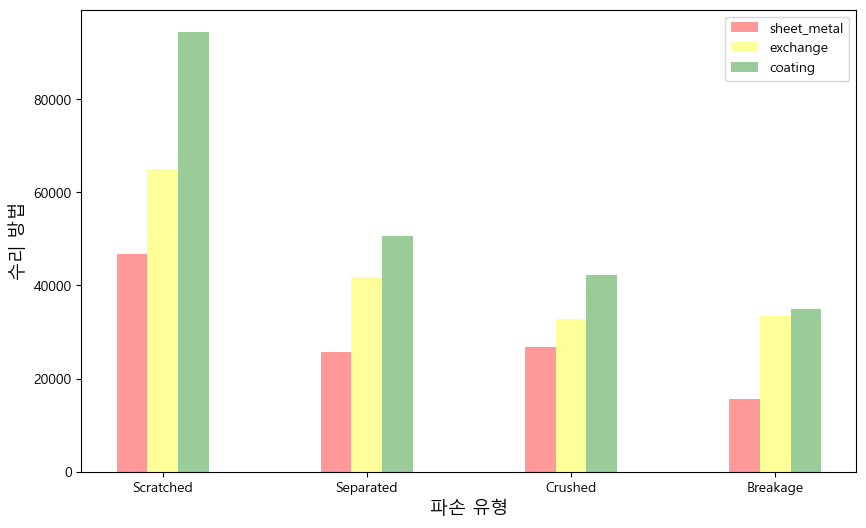

In [100]:
# 그림 사이즈, 바 굵기 조정
plt.subplots(figsize=(10,6))
bar_width = 0.15

# 수리 방법이 4개이므로 0, 1, 2, 3 위치를 기준으로 삼음
index = np.arange(4)

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, count['sheet_metal'], bar_width, alpha=0.4, color='red', label='sheet_metal')
b2 = plt.bar(index + bar_width, count['exchange'], bar_width, alpha=0.4, color='yellow', label='exchange')
b3 = plt.bar(index + 2 * bar_width, count['coating'], bar_width, alpha=0.4, color='green', label='coating')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 파손 정보와 매칭
plt.xticks(np.arange(0.15, 4 + bar_width, 1), count.index)

# x축, y축 이름 및 범례 설정
plt.xlabel('파손 유형', size = 13)
plt.ylabel('수리 방법', size = 13)

plt.legend()
plt.show()

----

In [61]:
price = pd.read_csv("repair_price.csv")
price.head()

,category_id,coating,sheet_metal,exchange,total,repair,supercategory_name,damage
0,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Separated
1,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Scratched
2,as-0000025,488500,175000,145750,1121128,"['Front door', 'Rear fender', 'Front bumper', ...",Full-size car,Crushed
3,as-0000027,496500,262500,267750,1293228,"['Front door', 'Rear fender', 'Rear door', 'Re...",Mid-size car,Breakage
4,as-0000027,496500,262500,267750,1293228,"['Front door', 'Rear fender', 'Rear door', 'Re...",Mid-size car,Scratched


In [91]:
price[price["supercategory_name"]=="CityCar"].index

Int64Index([    49,     50,     51,     52,     98,    133,    134,    135,
               161,    162,
            ...
            232660, 232661, 232662, 232663, 232672, 232686, 232687, 232690,
            232691, 232692],
           dtype='int64', length=40100)

In [92]:
#### City car -> Compact car ####
price.loc[price[price["supercategory_name"]=="CityCar"].index, "supercategory_name"] = "Compact car"

In [93]:
price.groupby(["supercategory_name"])[["coating", "sheet_metal", "exchange", "total"]].mean().round()

,coating,sheet_metal,exchange,total
supercategory_name,,,,
Compact car,152423.0,60618.0,112087.0,436686.0
Full-size car,263665.0,97741.0,209844.0,715574.0
Mid-size car,192738.0,71341.0,151106.0,543426.0


In [94]:
price.groupby(["supercategory_name", "damage"])[["coating", "sheet_metal", "exchange", "total"]].mean().round()

coating  sheet_metal  exchange     total
supercategory_name damage                                              
Compact car        Breakage   141496.0      55732.0  135998.0  448344.0
                   Crushed    173471.0      73228.0  121328.0  490353.0
                   Scratched  145747.0      56640.0   94421.0  401302.0
                   Separated  153331.0      60038.0  119921.0  445828.0
Full-size car      Breakage   255537.0      94535.0  248448.0  743792.0
                   Crushed    288792.0     113289.0  229170.0  791361.0
                   Scratched  251950.0      89635.0  176721.0  653062.0
                   Separated  271093.0     102714.0  230898.0  753660.0
Mid-size car       Breakage   182951.0      64955.0  175416.0  551392.0
                   Crushed    226774.0      90430.0  169579.0  634034.0
                   Scratched  181850.0      65715.0  127552.0  494459.0
                   Separated  193322.0      71430.0  162684.0  557381.0

In [95]:
price.groupby(["damage"])[["coating", "sheet_metal", "exchange", "total"]].mean().round()

,coating,sheet_metal,exchange,total
damage,,,,
Breakage,186089.0,68217.0,179165.0,561476.0
Crushed,223298.0,89866.0,167109.0,622730.0
Scratched,186048.0,68020.0,128397.0,500872.0
Separated,196347.0,73984.0,163147.0,561989.0
